<h1 align="center">WAT Analysis</h1> 

#### This notebook is broken up into sections with bite-sized exercises for demonstrating processing of [WAT files](https://webarchive.jira.com/wiki/display/ARS/Datasets+Available). 

#### We have a setup phase and 5 exercises:
#### *Exercise 1*: MIME distribution
#### *Exercise 2*: Tag Cloud from Title terms
#### *Exercise 3*: Topic Modeling using LDA
#### *Exercise 4*: GeoIP Map
#### *Exercise 5*: Link Analysis

<h3 align="center">Setup</h3> 

### Set WAT data directory

In [1]:
wat_data_dir = '/ars-data/sample-wats-single/'

### Define Helper functions

In [2]:
import os
import json
import gzip
import time 
import warc
import urlparse
import fnmatch
import tldextract
from collections import Counter
from datetime import datetime
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from surt import surt
from wordcloud import WordCloud
import numpy as np
%matplotlib inline


import matplotlib.pyplot as plt

fig_size = plt.rcParams["figure.figsize"]
# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

tokenizer = RegexpTokenizer(r'\w+')
stop_words = stopwords.words("english")

def clean_text_string(text_string):
    #lower case, remove punctuation and stop words
    text = tokenizer.tokenize(text_string.lower())
    cleaned_text = ' '.join(filter(lambda z: z not in stop_words, text))
    return cleaned_text

def is_metadata_record(record):
    return record['Content-Type'] == 'application/json'

def extract_json_data_from_metadata_record(record):
    payload = record.payload.read()
    data = json.loads(payload)
    return data
    
def wat_processor(wat_data_dir, extract_func):
    extracted_data = []
    for dirpath, dirs, files in os.walk(wat_data_dir):
        for filename in fnmatch.filter(files, '*.wat.gz'):
            f = warc.WARCFile(fileobj=gzip.open(os.path.join(dirpath, filename)))
            file_extracted_data = filter(lambda x: x is not None, map(extract_func, f))
            extracted_data += file_extracted_data
    return extracted_data        

def url_resolve(page, base, url):
    if url is None or len(url) == 0:
        return None
    if (url.startswith("http://") or
        url.startswith("https://") or
        url.startswith("ftp://") or
        url.startswith("feed://") or
        url.startswith("mailto:") or
        url.startswith("mail:") or
        url.startswith("javascript:") or
        url.startswith("rtsp://")):
        return url
    if base is not None and len(base) > 0:
        try:
            #print "base is " + base
            abs_url = urlparse.urljoin(base, url)
            return abs_url
        except:
            return None
    if page is not None and len(page) > 0:
        try:
            #print "page is " + page
            abs_url = urlparse.urljoin(page, url)
            return abs_url
        except:
            return None
    return url
    
def extract_domain(url):
    try:
        result = tldextract.extract(url).registered_domain
        if result is '':
            result = 'other'
        return result
    except:
        return 'other'

/opt/conda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


<h3 align="center">Exercises</h3> 


### Exercise 1: MIME distribution

In [3]:
def extract_top_level_mime(mime):
    mimes = ['text', 'image', 'audio', 'video', 'application']
    if not mime:
        return 'other'
    if mime == 'warc/revisit':
        return 'revisit'
    mime = mime.lower().split("/")[0]
    if mime in mimes:
        return mime
    return 'other'

def extract_mime_from_wat(record):
    if not is_metadata_record(record):
        return None
    data = extract_json_data_from_metadata_record(record)
    try:
        url   = data['Envelope']['WARC-Header-Metadata']['WARC-Target-URI']
        ts    = data['Envelope']['WARC-Header-Metadata']['WARC-Date']
        ts_dt = datetime.strptime(ts, "%Y-%m-%dT%H:%M:%SZ")
        mime    = data['Envelope']['Payload-Metadata']['HTTP-Response-Metadata']['Headers']['Content-Type']
        result = ((url, ts_dt), mime)
        return result
    except:
        return None

#Load mime types from WAT data
mime_metadata = wat_processor(wat_data_dir, extract_mime_from_wat)

In [4]:
#print the first record
print(len(mime_metadata))
print(mime_metadata[0])

5376
((u'https://www.youtube.com/robots.txt', datetime.datetime(2011, 12, 20, 1, 30, 3)), u'text/plain')


In [5]:
# extract mime types per day
day_mime_metadata = map(lambda x: (x[0][1].strftime('%m/%d/%Y'), extract_top_level_mime(x[1])), mime_metadata)

In [6]:
# index by date
mime_types = mimes = ['text', 'image', 'audio', 'video', 'application', 'revisit', 'other']
days = set(map(lambda x: x[0], day_mime_metadata))

#initialization
day_mime_dict = dict()
for day in days:
    day_mime_dict[day] = dict()
    for mime in mime_types:
        day_mime_dict[day][mime] = 0

for day, mime in day_mime_metadata:
    day_mime_dict[day][mime] = day_mime_dict[day][mime] + 1
print day_mime_dict

        

{'12/20/2011': {'text': 3348, 'image': 1651, 'revisit': 0, 'application': 367, 'other': 9, 'video': 1, 'audio': 0}}


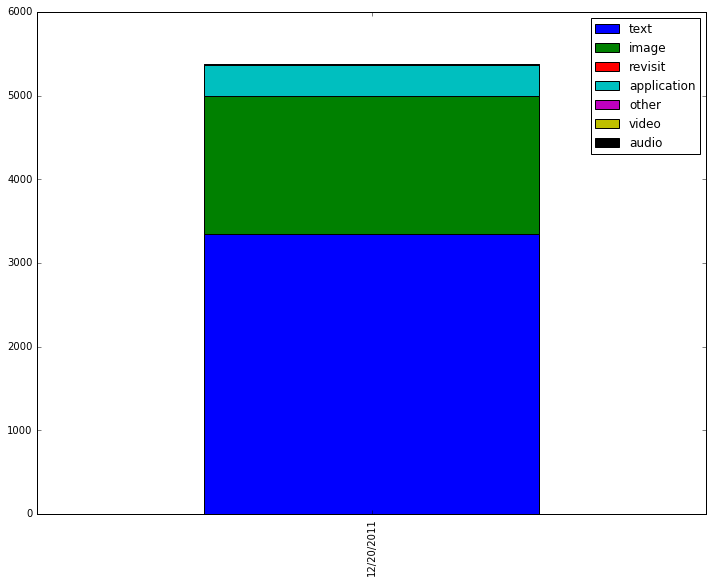

In [7]:
import pandas as pd

day_mime_df = pd.DataFrame.from_dict(day_mime_dict, orient='index')
column_index = day_mime_df.columns
day_mime_df.plot(kind='bar', stacked=True);

### Exercise 2: Tag Cloud from Title terms

In [8]:
def extract_title_from_wat(record):
    if not is_metadata_record(record):
        return None
    data = extract_json_data_from_metadata_record(record)
    #can only extract titles from metadata response records
    if data['Envelope']['WARC-Header-Metadata']['WARC-Type'] != 'response':
        return None
    try:
        url   = data['Envelope']['WARC-Header-Metadata']['WARC-Target-URI']
        ts    = data['Envelope']['WARC-Header-Metadata']['WARC-Date']
        ts_dt = datetime.strptime(ts, "%Y-%m-%dT%H:%M:%SZ")
        title = data['Envelope']['Payload-Metadata']['HTTP-Response-Metadata']['HTML-Metadata']['Head']['Title']
        result = ((url, ts_dt), title)
        return result
    except:
        return None

#Load title text from WAT data
title_metadata = wat_processor(wat_data_dir, extract_title_from_wat)

In [9]:
#print the first record
print(title_metadata[0])

((u'https://www.youtube.com/user/occupytv/', datetime.datetime(2011, 12, 20, 1, 30, 4)), u' OccupyTV&#39;s Channel - YouTube ')


In [10]:
#Clean title strings
cleaned_title_metadata = map(lambda x: (x[0], clean_text_string(x[1])), title_metadata)

print(title_metadata[10])
print(cleaned_title_metadata[10])

((u'https://www.youtube.com/', datetime.datetime(2011, 12, 20, 1, 30, 8)), u' YouTube - Broadcast Yourself. ')
((u'https://www.youtube.com/', datetime.datetime(2011, 12, 20, 1, 30, 8)), u'youtube broadcast')


In [11]:
#aggregate all title terms and count them
term_counter = Counter()
term_counter_list = map(lambda x: Counter(x[1].split()), cleaned_title_metadata)

for counter in term_counter_list:
    term_counter += counter

In [12]:
#print most frequent terms with their frequencies
print(term_counter.most_common(20))

[(u'found', 208), (u'youtube', 199), (u'blog', 194), (u'like', 181), (u'404', 149), (u'alexander', 132), (u'higgins', 131), (u'occupy', 94), (u'039', 67), (u'occupywallstreet', 66), (u'taylor', 59), (u'matthew', 59), (u'police', 57), (u'moved', 51), (u'help', 49), (u'39', 47), (u'us', 46), (u'page', 46), (u'nuclear', 45), (u'news', 43)]


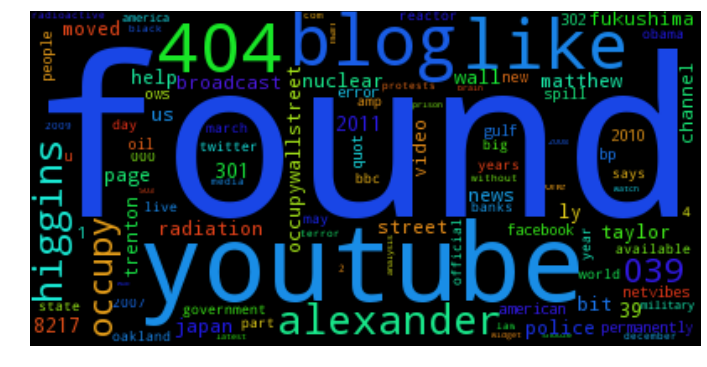

In [13]:
#generate a word cloud using the top n terms
top_n = 100
wordcloud = WordCloud().generate_from_frequencies(term_counter.most_common(top_n))
plt.axis("off")
plt.imshow(wordcloud)

### Exercise 3: Topic Modeling using [Latent Dirichlet allocation (LDA)](http://pythonhosted.org/lda/)

In [14]:
def extract_text_from_wat(record):
    if not is_metadata_record(record):
        return None
    data = extract_json_data_from_metadata_record(record)
    #can only extract text from metadata response records
    if data['Envelope']['WARC-Header-Metadata']['WARC-Type'] != 'response':
        return None
    try:
        url   = data['Envelope']['WARC-Header-Metadata']['WARC-Target-URI']
        ts    = data['Envelope']['WARC-Header-Metadata']['WARC-Date']
        ts_dt = datetime.strptime(ts, "%Y-%m-%dT%H:%M:%SZ")
        title = data['Envelope']['Payload-Metadata']['HTTP-Response-Metadata']['HTML-Metadata']['Head']['Title']
        meta  = data['Envelope']['Payload-Metadata']['HTTP-Response-Metadata']['HTML-Metadata']['Head']['Metas']
        keywords = ''
        for elem in meta:
            if elem['name'] == 'keywords':
                keywords = elem['content']
                break
        description = ''
        for elem in meta:
            if elem['name'] == 'description':
                description = elem['content']
                break
        text_terms = title + " " + keywords + " " + description
        result = ((url, ts_dt), text_terms)
        return result
    except:
        return None


#Load text from WAT data
text_metadata = wat_processor(wat_data_dir, extract_text_from_wat)
print(text_metadata[0])

((u'https://www.youtube.com/user/occupytv/', datetime.datetime(2011, 12, 20, 1, 30, 4)), u' OccupyTV&#39;s Channel - YouTube  video, sharing, camera phone, video phone, free, upload Share your videos with friends, family, and the world')


In [15]:
# Let's consider the text from only the most recent capture of a URL
# store in a dictionary where key = url (SURT form), and the value is (ts, text)
text_metadata_dict = dict()
for elem in text_metadata:
    url   = surt(elem[0][0])
    ts    = elem[0][1]
    text  = elem[1]
    if url in text_metadata_dict:
        if text_metadata_dict[url][0] < ts:
            text_metadata_dict[url] = (ts, text)
    else:
        text_metadata_dict[url] = (ts, text)

In [16]:
# Let's create a dataset (key = unique URL, value = term frequencies from cleaned text)
doc_set = dict()
for key, value in text_metadata_dict.items():
    ts   = value[0]
    text = value[1]
    doc_set[key] = Counter(clean_text_string(text).split())

print(len(doc_set))

122


In [17]:
import pandas as pd

doc_word = pd.DataFrame.from_dict(doc_set, orient='index')
# fill in nans
doc_word.fillna(0, inplace=True)
# lda requires ints
doc_word = doc_word.astype(int)
doc_count=doc_word.sum(axis='columns')
doc_word = doc_word[doc_count != 0]
column_index = doc_word.columns
print(len(column_index))

1223


In [18]:
import lda

num_topics = 3
start_time = time.time()
model = lda.LDA(n_topics=num_topics, n_iter=1000, random_state=1)
model = model.fit(doc_word.values) 
end_time   = time.time()
print("time taken (in seconds): ", end_time - start_time)

('time taken (in seconds): ', 4.8222949504852295)


In [19]:
column_sum = np.sum(model.doc_topic_, axis=0)
column_sum

array([ 53.57426936,  33.1624432 ,  35.26328744])

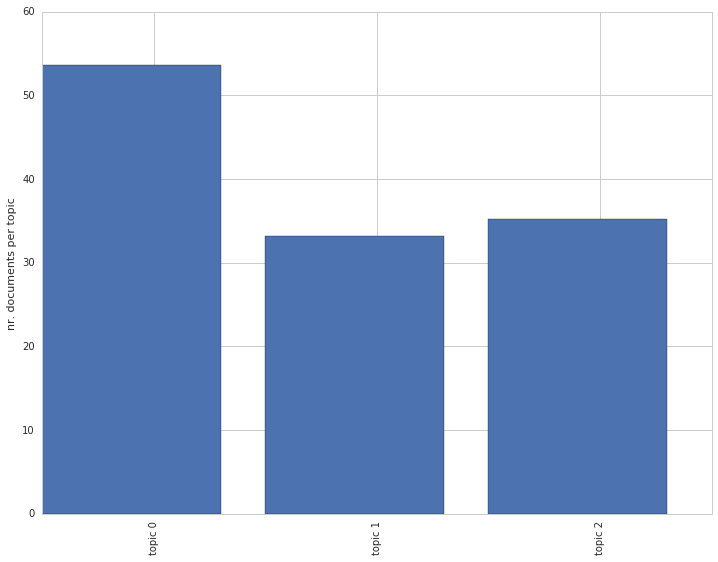

In [20]:
import seaborn as sns

fig_size = plt.rcParams["figure.figsize"]
# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

sns.set_style('whitegrid')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(num_topics), column_sum)
ax.set_ylabel('nr. documents per topic')
ax.set_xticklabels(['topic {}'.format(i) for i in range(num_topics)], rotation=90)
ax.set_xticks(np.arange(num_topics)+0.5)
plt.show()

In [21]:
doc_word.columns
model.topic_word_  
model.nzw_
sort_topic=np.argsort(model.nzw_[0,:])

topic_word = model.topic_word_  
n_top_words = 12
word_array = np.array(doc_word.columns)
#for i, topic in enumerate(topic_word):
#    topic_words = word_array[np.argsort(topic)][:-n_top_words:-1]
#    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

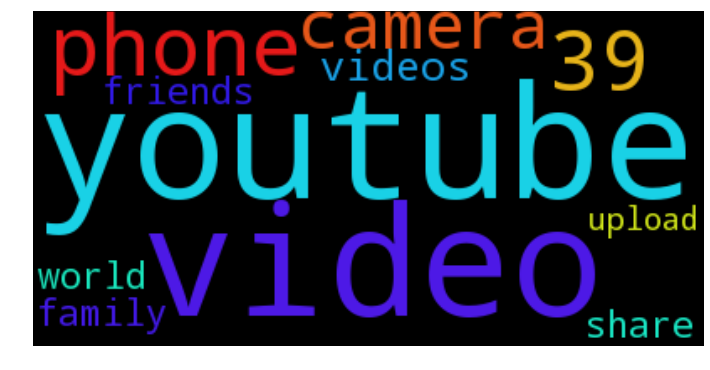

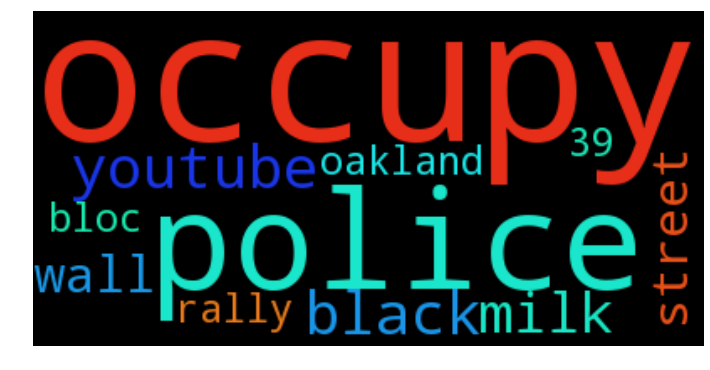

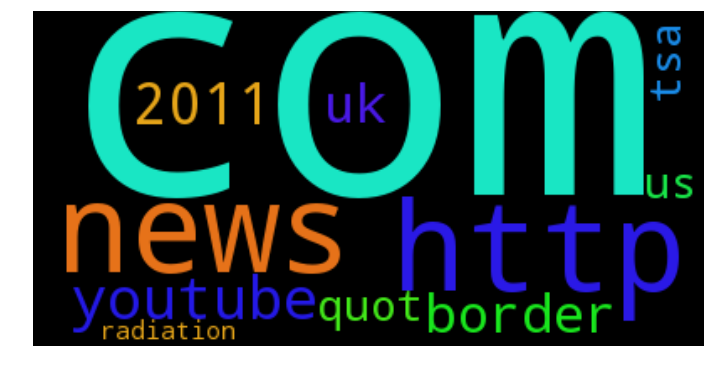

In [22]:
model_counts = np.array(model.nzw_).T
tuple_word_count = [0]*num_topics

for i, topic in enumerate(topic_word):
    sort_topic = np.argsort(topic)
    sort_model_counts = list(model_counts[sort_topic][:-n_top_words:-1][:,i])
    sorted_words = list(word_array[sort_topic][:-n_top_words:-1])
    tuple_word_count[i] = list(zip(sorted_words,sort_model_counts))
    
wordcloudobj = WordCloud(background_color='black')
for i,topic in enumerate(topic_word):
    wordcloud = wordcloudobj.generate_from_frequencies(tuple_word_count[i])
    plt.axis("off")
    plt.imshow(wordcloud)
    plt.show()

### Exercise 4: GeoIP Map


In [23]:
from geoip import geolite2

def extract_ip_from_wat(record):
    if not is_metadata_record(record):
        return None
    data = extract_json_data_from_metadata_record(record)
    try:
        url   = data['Envelope']['WARC-Header-Metadata']['WARC-Target-URI']
        ts    = data['Envelope']['WARC-Header-Metadata']['WARC-Date']
        ts_dt = datetime.strptime(ts, "%Y-%m-%dT%H:%M:%SZ")
        ip    = data['Envelope']['WARC-Header-Metadata']['WARC-IP-Address']
        result = ((url, ts_dt), ip)
        return result
    except:
        return None

ip_metadata = wat_processor(wat_data_dir, extract_ip_from_wat)

In [24]:
ips = map(lambda x: x[1], ip_metadata)
ips = set(ips)
ip_lookup = filter(lambda x: x is not None, map(lambda x: geolite2.lookup(x), ips))

ip_locations = filter(lambda x: x is not None, map(lambda x: x.location, ip_lookup))
ip_locations = list(set(ip_locations))

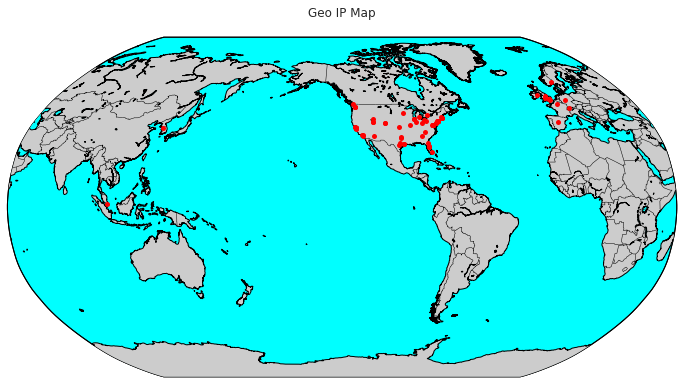

In [25]:
from mpl_toolkits.basemap import Basemap

geo_map = Basemap(projection='robin', resolution = 'l', area_thresh = 1000.0, lat_0=0, lon_0=-130)
geo_map.drawcoastlines()
geo_map.drawcountries()

min_marker_size = 5.0
for lat, lon in ip_locations:
    x,y = geo_map(lon, lat)
    geo_map.plot(x, y, 'ro', markersize=min_marker_size)

geo_map.drawmapboundary(fill_color='aqua')
geo_map.fillcontinents(color='0.8',lake_color='aqua')
title_string = "Geo IP Map\n"
plt.title(title_string)
plt.show()

### Exercise 5: Link Extraction

In [26]:
def extract_links_from_wat(record):
    if not is_metadata_record(record):
        return None
    data = extract_json_data_from_metadata_record(record)
    #can only extract text from metadata response records
    if data['Envelope']['WARC-Header-Metadata']['WARC-Type'] != 'response':
        return None
    result_links = []
    try:
        url   = data['Envelope']['WARC-Header-Metadata']['WARC-Target-URI']
        ts    = data['Envelope']['WARC-Header-Metadata']['WARC-Date']
        ts_dt = datetime.strptime(ts, "%Y-%m-%dT%H:%M:%SZ")
        base  = data['Envelope']['Payload-Metadata']['HTTP-Response-Metadata']['HTML-Metadata']['Head']['Base']
        links = data['Envelope']['Payload-Metadata']['HTTP-Response-Metadata']['HTML-Metadata']['Links']
        for link in links:
            #url,path,text,alt
            dst_url   = link.get('url', '')
            path      = link.get('path', '')
            link_text = link.get('text', '')
            if 'alt' in link:
                link_text = link.get('alt', '')
            #print "dst_url is " + dst_url
            abs_dst_url = url_resolve(url, base, dst_url)
            #print "abs_dst_url is " + abs_dst_url
            if abs_dst_url is None:
                return None
            res_link = (abs_dst_url, path, link_text)
            #print res_link
            result_links.append(res_link)
        return ((url, ts_dt), result_links)
    except:
        return None


#Load links from WAT data
links_metadata = wat_processor(wat_data_dir, extract_links_from_wat)
#key = (url,ts)
#value = array of links where each link is a tuple(dst_url, link_type, link_text)
#print an example record
#print(links_metadata[0])

#### (5a) Top Anchor terms per domain

In [27]:
#for each link in the corpus
#extract the associated domain, and the anchor text
domain_anchor_text = []
out_links = map(lambda x: x[1], links_metadata)
for link_array in out_links:
    for (dst_url, link_type, link_text) in link_array:
        domain_dst = extract_domain(dst_url)
        link_text = clean_text_string(link_text)
        if link_text is not '':
            domain_anchor_text.append((extract_domain(dst_url), clean_text_string(link_text)))

In [28]:
#aggregate all anchor terms per domain and count them
domain_anchor_term_counter = dict()
for (domain, anchor_text) in domain_anchor_text:
    old_counter = domain_anchor_term_counter.get(domain, Counter())
    new_counter = Counter(anchor_text.split(' '))
    domain_anchor_term_counter[domain] = old_counter + new_counter

In [29]:
print domain_anchor_term_counter.keys()

[u'yahoo.com', u'aclu.org', u'rcpsych.ac.uk', u'psychiatrycpd.co.uk', u'bma.org.uk', u'un.org', u'twitter.com', u'amazonaws.com', 'other']


6	twitter
4	forgot
4	mobile
2	already
2	help
2	advertisers
2	site
2	sign
2	via
2	businesses
2	jobs
2	privacy
2	media
2	sms
2	blog
2	new
2	developers
2	today
2	status
2	terms


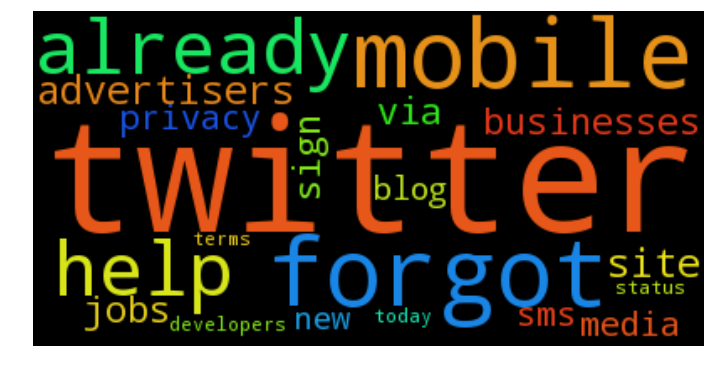

In [30]:
#print  example
domain = 'twitter.com'
most_common = domain_anchor_term_counter[domain].most_common(20)

for x in most_common:
    term = x[0]
    count = x[1]
    print str(count) + "\t" + term
    
#generate a word cloud using the top X terms
wordcloud = WordCloud().generate_from_frequencies(most_common)
plt.axis("off")
plt.imshow(wordcloud)

#### (5b) Domain Graph

In [31]:
#generate domain graph from link data
#key = (url,ts)
#value = array of links where each link is a tuple(dst_url, link_type, link_text)
#print an example record

domain_graph = dict()
for (key, value) in links_metadata:
    src_url = key[0]
    src_domain = extract_domain(src_url)
    if src_domain not in domain_graph:
        domain_graph[src_domain] = dict()
    for (dst_url, link_type, link_text) in value:
        dst_domain = extract_domain(dst_url)
        link_count = domain_graph[src_domain].get(dst_domain, 0)
        domain_graph[src_domain][dst_domain] = link_count + 1


In [32]:
print domain_graph.keys()

[u'rblack.org', u'rcpsych.ac.uk', u'twitter.com', u'aclu.org']


In [33]:
#print domain level links for example domain
print domain_graph['aclu.org']

{u'aclu.org': 26, u'charitynavigator.org': 1, 'other': 1, u'bbb.org': 1}


In [34]:
import networkx as nx
N = nx.DiGraph()

# set the set of nodes to be considered for extracting outgoing links -- all other nodes are ignored
nodes_to_consider = ['aclu.org']

for src in domain_graph.keys():
    #print src
    # apply filters here as needed
    if src not in nodes_to_consider:
        continue
    out_domain_dict = domain_graph[src]
    out_domains_list = domain_graph[src].keys()
    N.add_nodes_from(out_domains_list)
    for dst in out_domains_list:
        #skip self loops
        if dst == src:
            continue
        N.add_edge(src, dst, weight=domain_graph[src][dst])
            
edge_labels = dict([((u,v,), d['weight']) for u,v,d in N.edges(data=True)])
print(N.nodes())
print(N.edges())

[u'bbb.org', u'aclu.org', 'other', u'charitynavigator.org']
[(u'aclu.org', u'bbb.org'), (u'aclu.org', 'other'), (u'aclu.org', u'charitynavigator.org')]


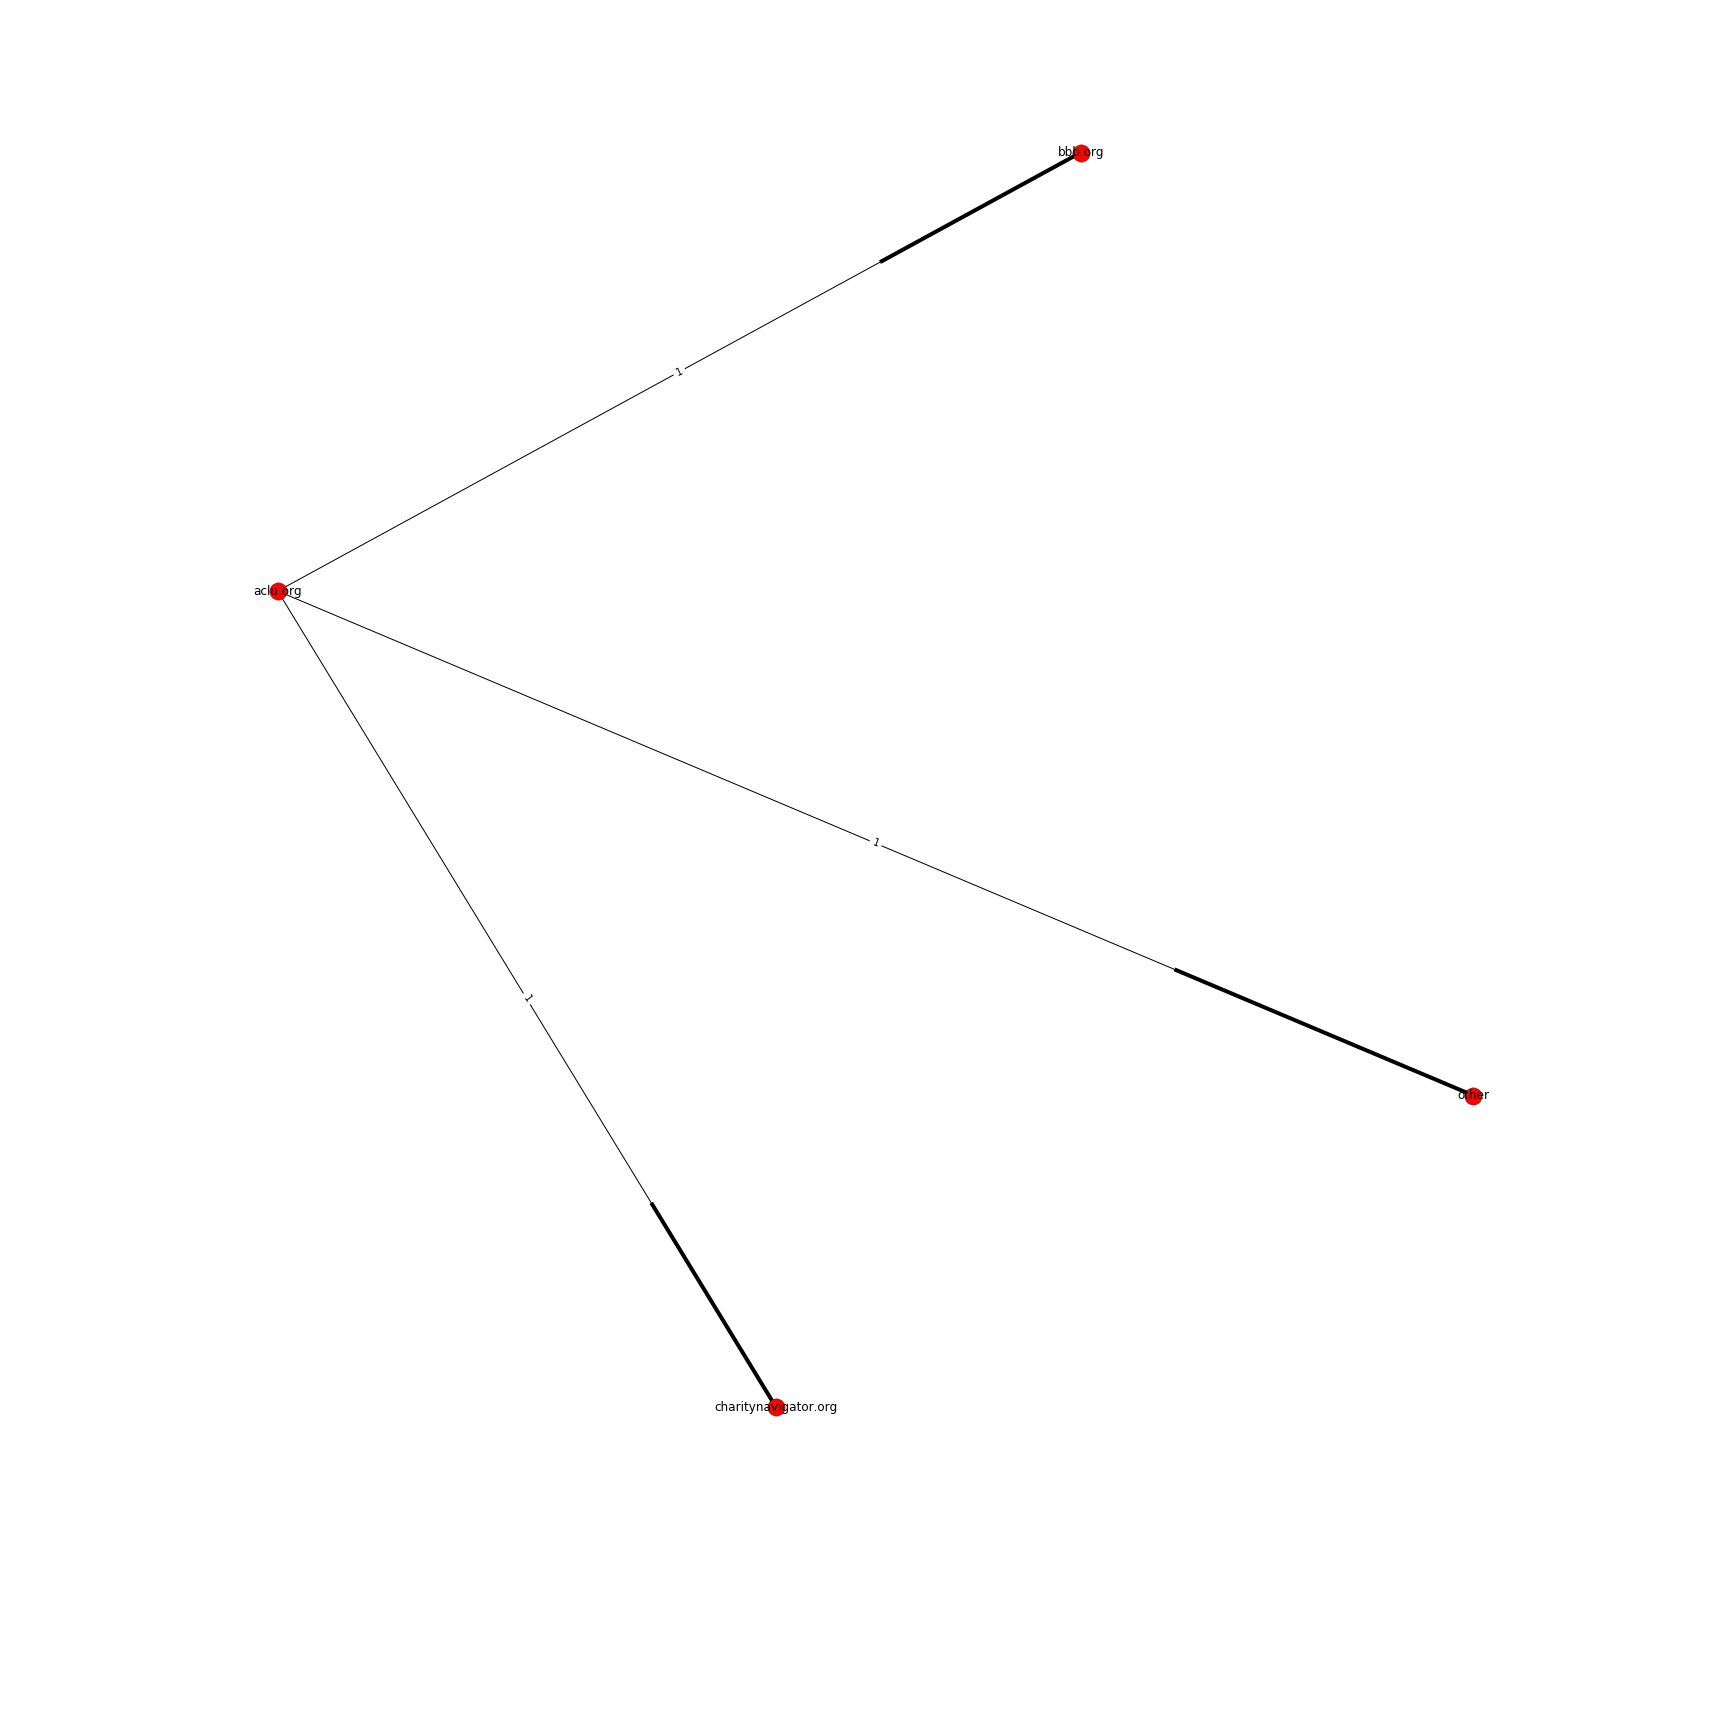

In [35]:
import matplotlib.pyplot as plt

# set the graphic inline in screen
# set the figure size
%matplotlib inline
plt.figure(figsize=(30,30))

# layouts
pos = nx.fruchterman_reingold_layout(N)
#pos = nx.circular_layout(N)
#pos = nx.spring_layout(N)
#pos = nx.spectral_layout(N)

# set the labels, draw the graph
nx.draw_networkx_edge_labels(N, pos, edge_labels=edge_labels)
nx.draw_networkx_labels(N, pos)
nx.draw(N, pos)